## Importing Required Packages

In [70]:
import os
import calendar
from pathlib import Path # to interact with file system.
import numpy as np # for working with arrays.
import networkx as nx
import pandas as pd # for working with data frames (tables).
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns # Making statistical graphs on top of what matplot can do 

from sklearn import preprocessing


%matplotlib inline

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

## ----------Question1------------

## loading the dataset

In [3]:
carvana_df = pd.read_csv('training.csv')
carvana_df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


## creating a heatmap to understand the what all factors are impacting the price

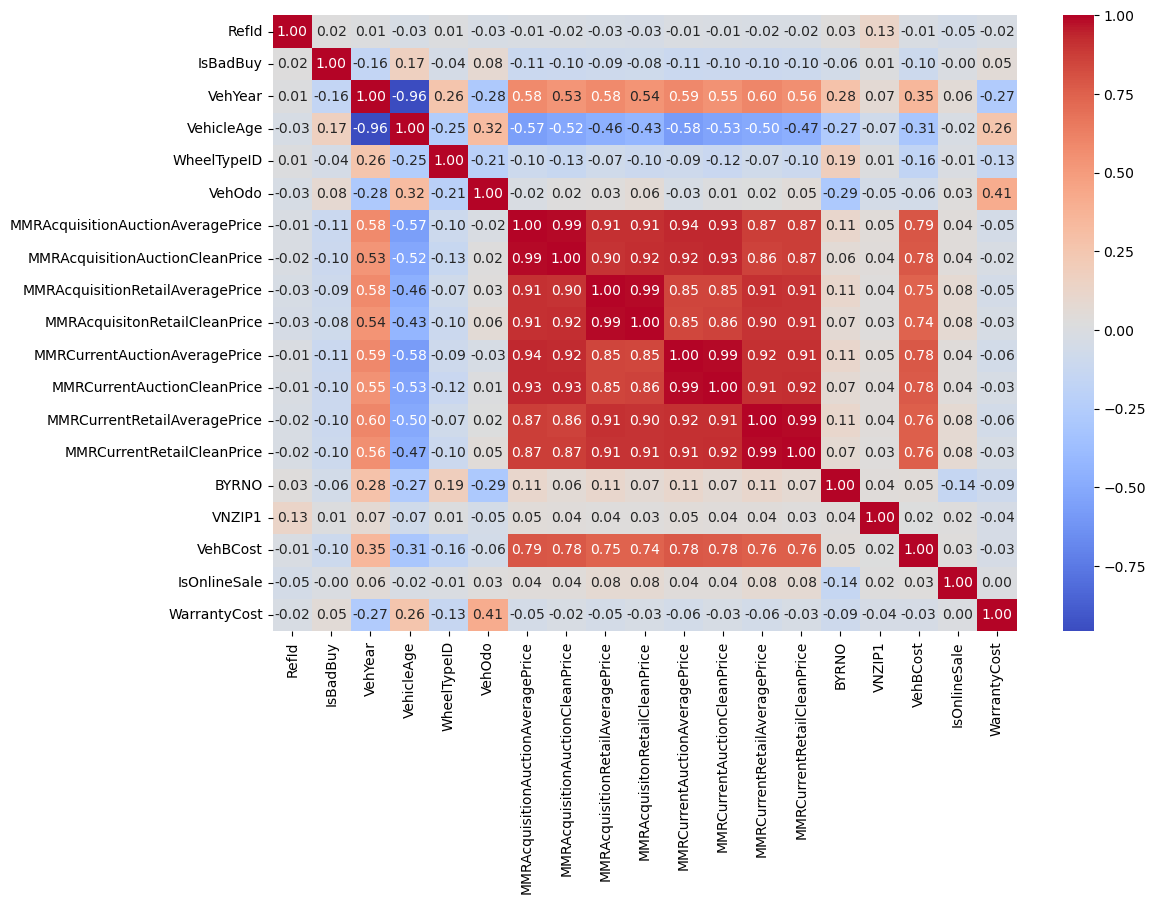

In [33]:
corr = carvana_df.corr()
plt.figure(figsize=(12, 8))  #figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

## Time Series Plot of Purchase Date: Analyze the number of bad buys over time to see if there are any trends related to the purchase date. (important finding)

## Histogram between Vehicle Odometer Reading and Bad Buys Proportion (important finding)

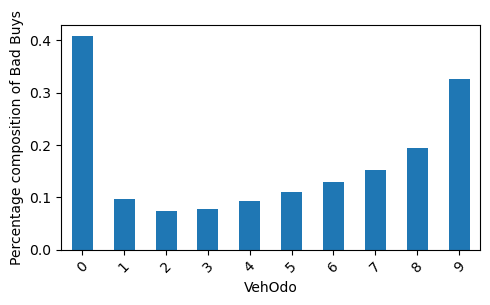

In [32]:
dataForPlot = carvana_df.groupby(pd.cut(carvana_df.VehOdo, bins=10, right=True)).mean()['IsBadBuy'] #making 10 buckets
ax = dataForPlot.plot(kind='bar', figsize=[5, 3])
ax.set_ylabel('Percentage composition of Bad Buys')
ax.set_xticklabels(ax.get_xticks(), rotation = 45)

plt.tight_layout()
plt.show()

## We can see that Vehicle Odometer reading of very less and very high value have higher composition of bad buys. May be there is something wrong with the car and that is why it has not been driven, which is why it is a bad buy. And for higher readings, it could be the usual wear and tear.

## comparing for the size of vehicles  to see if certain sizes are more prone to being bad buys.

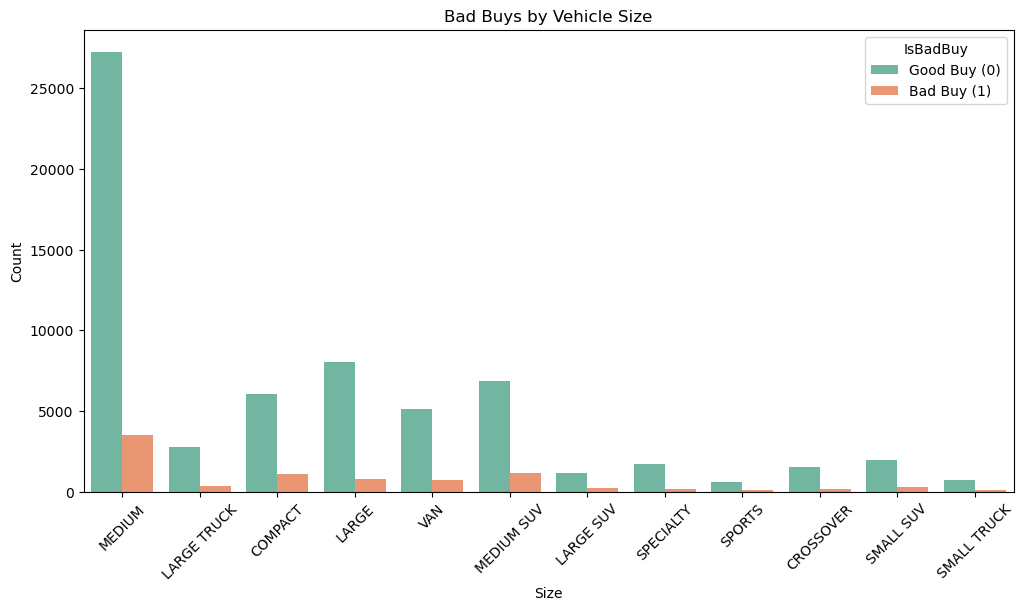

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=carvana_df, x='Size', hue='IsBadBuy', palette='Set2')
plt.title('Bad Buys by Vehicle Size')
plt.xlabel('Size')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='IsBadBuy', loc='upper right', labels=['Good Buy (0)', 'Bad Buy (1)'])

plt.show()

## proportion of bad buys with respect to vehicle age (important finding)

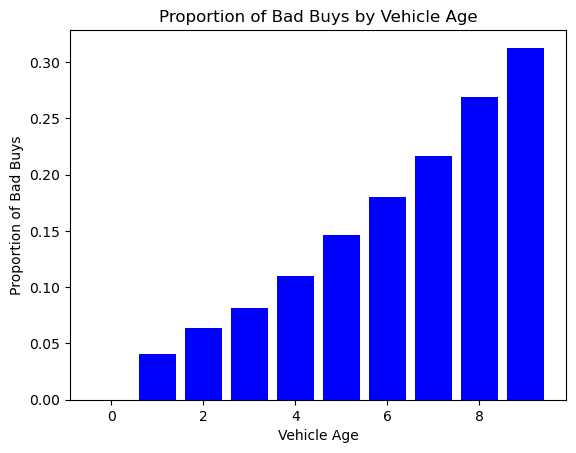

In [8]:
# Group data by VehicleAge and calculate the average IsBadBuy proportion
age_badbuy = carvana_df.groupby('VehicleAge')['IsBadBuy'].mean()

# Create a bar chart
plt.bar(age_badbuy.index, age_badbuy, color='blue')

# Set labels and title
plt.xlabel('Vehicle Age')
plt.ylabel('Proportion of Bad Buys')
plt.title('Proportion of Bad Buys by Vehicle Age')

# Show the plot
plt.show()

## The proportion of bad buys is more in aged cars, the proportion of bad buys is just 0.04 is cars of age 1, whereas this proportion is 0.3 in cars of age 9.

## Bad Buys by Wheel Type 

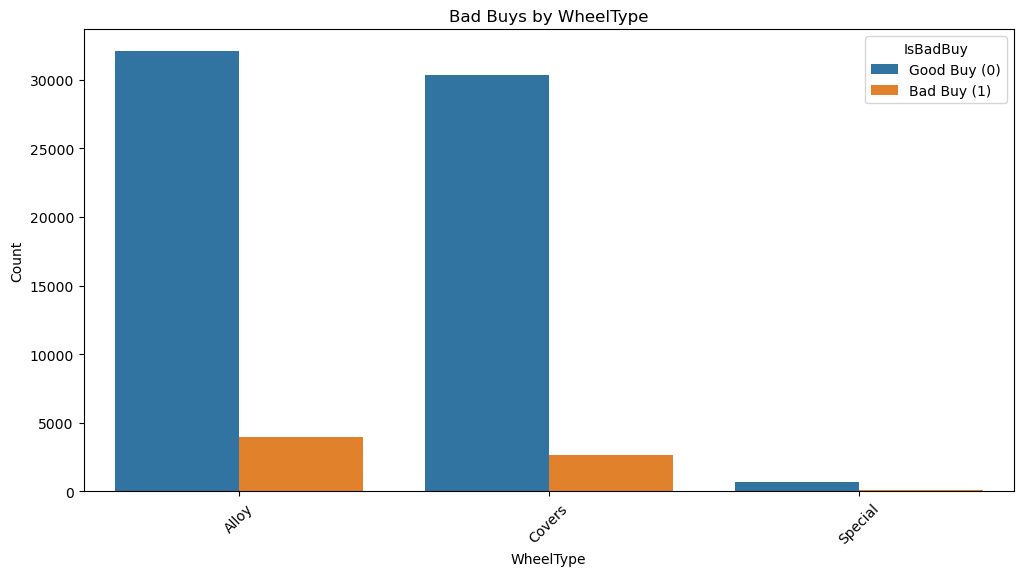

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(data=carvana_df, x='WheelType', hue='IsBadBuy')
plt.title('Bad Buys by WheelType')
plt.xlabel('WheelType')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='IsBadBuy', loc='upper right', labels=['Good Buy (0)', 'Bad Buy (1)'])

plt.show()

## Trying to find out if IsBadBuy has a relationship with MMRAcquisitionAuctionAveragePrice, like if their median cost varies or not (Important finding)

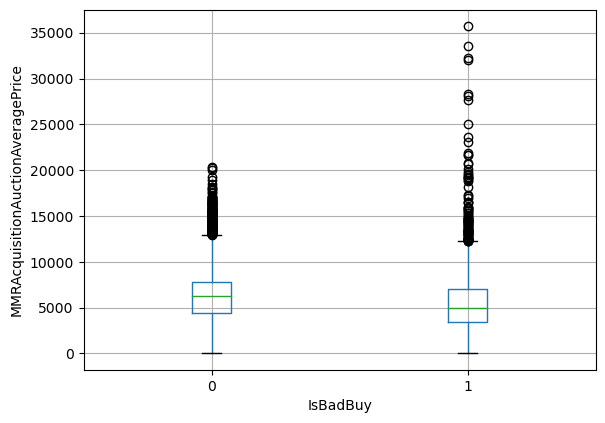

In [28]:
ax = carvana_df.boxplot(column='MMRAcquisitionAuctionAveragePrice', by='IsBadBuy')
ax.set_ylabel('MMRAcquisitionAuctionAveragePrice')
plt.suptitle('')  # Suppress the titles
plt.title('')

plt.show()

## This graph supports our claim that MMRAcquisitionAuctionAveragePrice is a leading indicator for IsbadBuy. The median cost (MMRAcquisitionAuctionAveragePrice) of a bad buy is less than the median cost (MMRAcquisitionAuctionAveragePrice) of a Good buy

## Recommendations
1. Pay extra surveillance/attention on cars with low odometer reading. According to our analysis, even the cars with less odometer reading have a proportion of 0.4 of bad buys. (out of every 10 cars, 4 are bad buys in cases of cars with low odometer reading)
2. Do not bid higher for aged cars, as there is a 30% chance that an aged car could be a bad buy.
3. From a domain expert, try to find the reasons of the peaks during Sept 2009, Feb 2010, Jan 2011. Some external factors like supply chain of cars could be the potential reason

## ----------Question2--------------

In [11]:
#loading the dataset and creating dataframe
Airfares_df = pd.read_csv('Airfares.csv')

In [12]:
Airfares_df.head()

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47


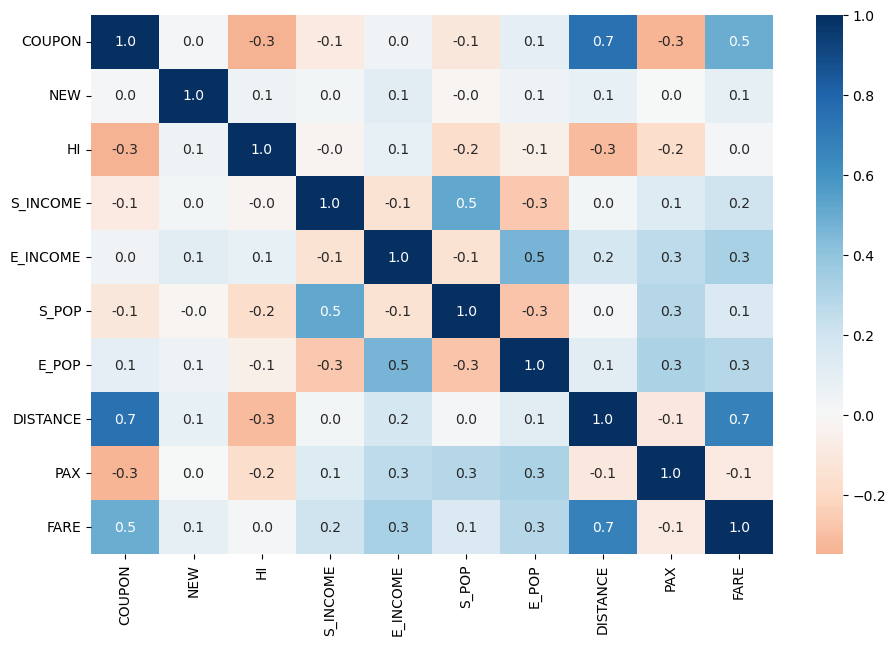

In [13]:
corr = Airfares_df.corr()

# Include information about values
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

plt.show()

##Observtion from the corelation matrix
1. Coupon has a positive corelation with Fare (0.5)
2. Distance is also directly co-related with Fare, with a co-relation coefficient of 0.7
3. Other variables like S_Income and E_income are also positively related with Fare, but the corerelation coefficient is only 0.3

## Plot between Fare V/s Distance & Fare V/s Coupon

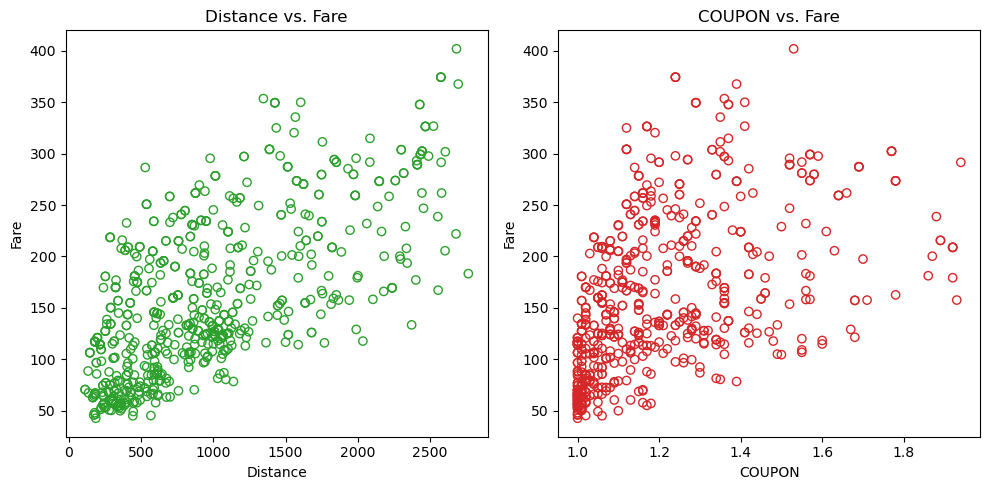

In [35]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot 1: Distance vs. Fare
ax1.scatter(Airfares_df.DISTANCE, Airfares_df.FARE, color='C2', facecolor='none')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Fare')
ax1.set_title('Distance vs. Fare')

# Scatter plot 2: COUPON vs. Fare
ax2.scatter(Airfares_df.COUPON, Airfares_df.FARE, color='C3', facecolor='none')
ax2.set_xlabel('COUPON')
ax2.set_ylabel('Fare')
ax2.set_title('COUPON vs. Fare')

plt.tight_layout()
plt.show()



## OBSERVATIONS USING THE SCATTER PLOTS:

##### The Scatter plots are used to determine the pattern and the type of correlation between these variable that show strong correlation.
##### The scatter plot for FARE and DISTANCE shows a clear positive linear relationship. As the distance increases, the fare tends to increase, which is in line with the strong positive correlation you found in the heatmap.
##### The scatter plot for FARE and COUPON also indicates a positive linear relationship. This suggests that as the coupon value increases, fares tend to increase, which aligns with the moderate positive correlation observed in the heatmap.

## Using Boxplots to analyze the effect of categorical predictors on FARE. 
<li> VACATION </li> <li> SW </li> <li> SLOT </li> <li> GATE </li>

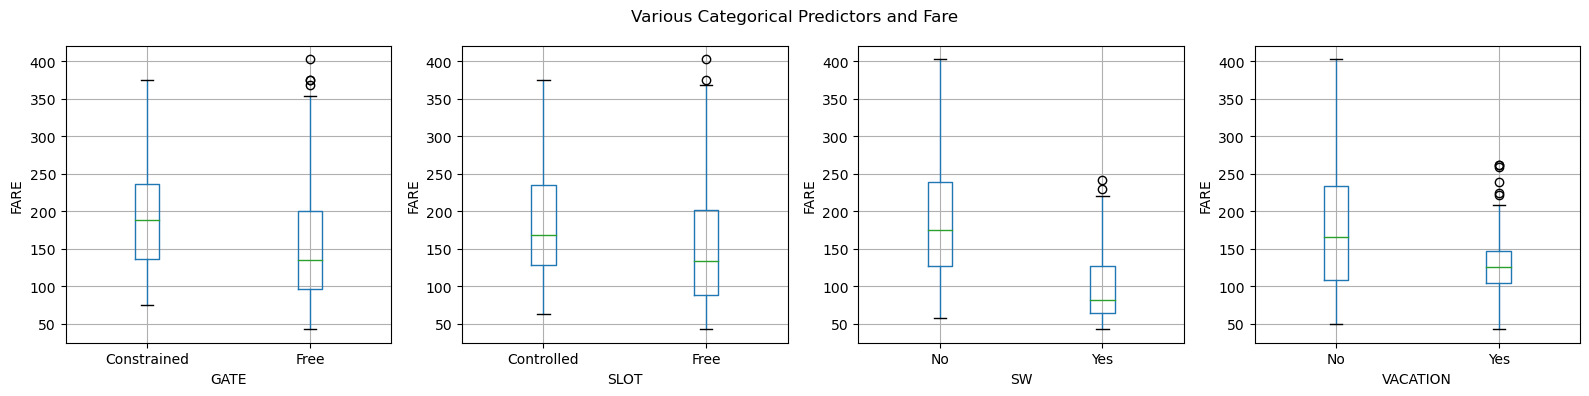

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
Airfares_df.boxplot(column='FARE', by='GATE', ax=axes[0])
Airfares_df.boxplot(column='FARE', by='SLOT', ax=axes[1])
Airfares_df.boxplot(column='FARE', by='SW', ax=axes[2])
Airfares_df.boxplot(column='FARE', by='VACATION', ax=axes[3])

# Set y-axis label
for ax in axes:
    ax.set_ylabel('FARE')
    

# Set titles to empty
for ax in axes:
    ax.set_title('')

plt.suptitle('Various Categorical Predictors and Fare')  
plt.tight_layout()  # Increase the separation between the plots

plt.show()

## Observations on the effect of categorical variables on Fare
1. The Variable SW is effecting the Fare very much, if SW is yes then the median fare is around 75, whereas if SW is No then the median Fare is 175
2. Whether it is vacation time or not, is also significantly impacting the fare price, if it is vacation then the median fare is around 125, Also there are outliers which is a common scenario when fares are high for the last minute bookings.
3. Similarly, if the gate is FREE then the Fares are less then the minimum fare of a constrained gate. This may be because of the infrastructure cost of a constrained gate.
4. There is also a  difference in the median fare of controlled slot v/s free slot. For controlled slots, the median fare is around 175, whereas for Free slot it is 140. 

## Creating the model. 
<UL> Based on our analysis till now, we are taking the following variables into our model </UL>
<li>  Categorical: Gate, Slot, SW and Vacation </li>
<li>  Numerical/Continuous: Distance and Coupon </li>

In [75]:
predictors = ['GATE', 'SLOT', 'SW', 'VACATION', 'DISTANCE', 'COUPON']
Airfares_df[predictors].dtypes

GATE         object
SLOT         object
SW           object
VACATION     object
DISTANCE      int64
COUPON      float64
dtype: object

The datatypes are correct for all variables, no need to convert

## Our Model

In [80]:
predictors = ['GATE', 'SLOT', 'SW', 'VACATION', 'DISTANCE', 'COUPON']
outcome = 'FARE'

# partition data
X = pd.get_dummies(Airfares_df[predictors],prefix_sep='_', drop_first=True)
print(Airfares_df[predictors].columns)
y = Airfares_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

airfare_lm = LinearRegression()
airfare_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', airfare_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': airfare_lm.coef_}))

# print performance measures
regressionSummary(train_y, airfare_lm.predict(train_X))

Index(['GATE', 'SLOT', 'SW', 'VACATION', 'DISTANCE', 'COUPON'], dtype='object')
intercept  163.32286492035965
      Predictor  coefficient
0      DISTANCE     0.077489
1        COUPON   -12.993141
2     GATE_Free   -27.208234
3     SLOT_Free   -15.072332
4        SW_Yes   -52.554128
5  VACATION_Yes   -49.925568

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 38.5010
            Mean Absolute Error (MAE) : 30.5706
          Mean Percentage Error (MPE) : -5.5247
Mean Absolute Percentage Error (MAPE) : 22.1450


In [82]:
pred_y = airfare_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, airfare_lm))
print('AIC : ', AIC_score(train_y, pred_y, airfare_lm))
print('BIC : ', BIC_score(train_y, pred_y, airfare_lm))

adjusted r2 :  0.7271591531330875
AIC :  3889.192676702756
BIC :  3920.756041571609


## Measuring the performance on Validation Set

In [84]:
# Use predict() to make predictions on a new set
airfare_lm_pred = airfare_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': airfare_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - airfare_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

      Predicted  Actual   Residual
101  181.796281  240.88  59.083719
619  291.384891  347.82  56.435109
616  268.238719  279.83  11.591281
446  147.362823  128.36 -19.002823
522  303.190939  289.25 -13.940939
525  244.518940  238.73  -5.788940
305  123.600964  140.90  17.299036
41   175.464765  250.73  75.265235
47   172.275759  230.87  58.594241
605  176.151759  164.30 -11.851759
455   77.742184  118.17  40.427816
523  315.326842  289.25 -26.076842
339  122.076045  105.41 -16.666045
69   164.276397  113.99 -50.286397
473  268.965535  248.49 -20.475535
460  195.830053  252.97  57.139947
635  130.304157  124.87  -5.434157
23    69.436014  106.77  37.333986
554   63.049027  106.65  43.600973
13   128.596068  132.05   3.453932

Regression statistics

                      Mean Error (ME) : -1.1219
       Root Mean Squared Error (RMSE) : 40.8149
            Mean Absolute Error (MAE) : 32.2007
          Mean Percentage Error (MPE) : -7.2845
Mean Absolute Percentage Error (MAPE) : 24.0312


## Plotting the residuals
Determine the residuals and create a histogram

1.0


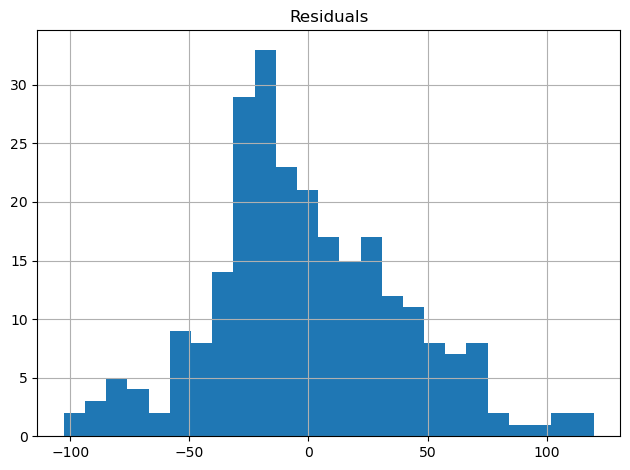

In [85]:
airfare_lm_pred = airfare_lm.predict(valid_X)
all_residuals = valid_y - airfare_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## as per the concept, the histogram of the residuals also look normally distributed